In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Reshape
import matplotlib.pyplot as plt

c:\Users\acer\anaconda3\envs\zhuge\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.18) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
# ==== CONFIG ====
csv_path = "sbc_counter_result.csv"

n_past = 24                   # số bước thời gian dùng làm input
target_counters = [6, 9]   # các counter_id cần DỰ ĐOÁN (n_counter)

# ==== LOAD & PIVOT ====
df = pd.read_csv(csv_path)

# bỏ cột không dùng
df = df.drop(columns=['id', 'counter_option'])

# chuẩn hóa thời gian
df['trigger_time'] = pd.to_datetime(df['trigger_time'], unit='s')
df = df.sort_values('trigger_time')

# === pivot TẤT CẢ counter làm feature ===
# index = time, columns = (node_id, counter_id), value = counter_value
df_pivot = df.pivot_table(
    index='trigger_time',
    columns=['node_id', 'counter_id'],
    values='counter_value'
)

df_pivot = df_pivot.sort_index(axis=1)   # sắp xếp cột theo (node_id, counter_id)

print("df_pivot shape:", df_pivot.shape)     # (n_time, n_nodes * n_all_counters)
print("Một vài cột:", df_pivot.columns[:10])
df_pivot.head()

df_pivot shape: (26209, 120)
Một vài cột: MultiIndex([(1,  1),
            (1,  2),
            (1,  3),
            (1,  4),
            (1,  5),
            (1,  6),
            (1,  7),
            (1,  8),
            (1,  9),
            (1, 10)],
           names=['node_id', 'counter_id'])


node_id                    1                                               \
counter_id                1        2        3        4        5        6    
trigger_time                                                                
2025-09-07 18:39:27  22695.0  20238.0  20681.0  19287.0  22703.0  18683.0   
2025-09-07 18:44:27  21120.0  19911.0  21249.0  21861.0  18355.0  20104.0   
2025-09-07 18:49:27  19024.0  20255.0  19361.0  21907.0  18896.0  19823.0   
2025-09-07 18:54:27  19199.0  23258.0  20103.0  19764.0  18378.0  19695.0   
2025-09-07 18:59:27  20564.0  22984.0  17187.0  19524.0  21141.0  20346.0   

node_id                                                  ...        6  \
counter_id                7        8        9        10  ...       11   
trigger_time                                             ...            
2025-09-07 18:39:27  19338.0  19689.0  17477.0  18901.0  ...  23816.0   
2025-09-07 18:44:27  22204.0  20710.0  19171.0  21094.0  ...  20085.0   
2025-09-07 18:49:27  19579.0  18229.0  21886.0  19680.0  ...  20821.0   
2025-09-07 18:54:27  18769.0  19945.0  20138.0  18877.0  ...  17981.0   
2025-09-07 18:59:27  18875.0  20374.0  20394.0  17472.0  ...  19279.0   

node_id                                                                    \
counter_id                12       13       14       15       16       17   
trigger_time                                                                
2025-09-07 18:39:27  18616.0  19922.0  20057.0  18213.0  18327.0  17304.0   
2025-09-07 18:44:27  18478.0  21396.0  21944.0  20388.0  18512.0  20991.0   
2025-09-07 18:49:27  19749.0  17640.0  22354.0  21744.0  16455.0  18865.0   
2025-09-07 18:54:27  19731.0  18713.0  19907.0  21435.0  18740.0  21203.0   
2025-09-07 18:59:27  19909.0  21264.0  20723.0  19466.0  23496.0  24569.0   

node_id                                         
counter_id                18       19       20  
trigger_time                                    
2025-09-07 18:39:27  19542.0  21080.0  22515.0  
2025-09-07 18:44:27  19283.0  18880.0  18020.0  
2025-09-07 18:49:27  19036.0  20220.0  17023.0  
2025-09-07 18:54:27  20388.0  21997.0  20412.0  
2025-09-07 18:59:27  19481.0  19262.0  20204.0  

[5 rows x 120 columns]

In [3]:
# Xử lý các cột (node_id, counter_id) = 0

# Tính tổng theo từng counter_id trên tất cả node
# sum_by_counter = df_pivot.groupby(level='counter_id', axis=1).sum()

# Các counter có tổng == 0 ở mọi thời điểm ⇒ toàn 0
# zero_counters = sum_by_counter.columns[(sum_by_counter == 0).all()]
# print("Counter_id toàn 0:", list(zero_counters))

# Xoá toàn bộ các cột có counter_id nằm trong zero_counters
# df_pivot = df_pivot.drop(columns=zero_counters, level='counter_id')

# print("df_pivot_clean shape:", df_pivot.shape)
# print("Các cột còn lại:", df_pivot.columns.tolist())
# print("\n=== df_pivot sau khi xoá counter toàn 0 ===")
# df_pivot

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_pivot.values)

n_time, n_features_all = data_scaled.shape
node_ids = df_pivot.columns.get_level_values(0).unique()
all_counters = df_pivot.columns.get_level_values(1).unique()

n_nodes = len(node_ids)
n_all_counters = len(all_counters)

print("n_time:", n_time)
print("n_features_all:", n_features_all)
print("n_nodes:", n_nodes, "n_all_counters:", n_all_counters)
print("node_ids: ", node_ids)

n_time: 26209
n_features_all: 120
n_nodes: 6 n_all_counters: 20
node_ids:  Index([1, 2, 3, 4, 5, 6], dtype='int64', name='node_id')


In [5]:
# Lấy MultiIndex columns
cols = df_pivot.columns  # MultiIndex (node_id, counter_id)

# Tìm index các cột có counter_id thuộc target_counters
target_col_indices = [
    i for i, (nid, cid) in enumerate(zip(cols.get_level_values(0), cols.get_level_values(1)))
    if cid in target_counters
]
print(target_col_indices)

print("Số cột target:", len(target_col_indices))
# n_target_features = n_nodes * n_target_counters
n_target_counters = len(target_counters)
assert len(target_col_indices) == n_nodes * n_target_counters

[5, 8, 25, 28, 45, 48, 65, 68, 85, 88, 105, 108]
Số cột target: 12


In [6]:
def create_xy_all_features_target_subset(
    data_scaled,
    n_past,
    target_col_indices,
    n_nodes,
    n_target_counters
):
    X, Y = [], []
    n_time, n_features_all = data_scaled.shape

    for i in range(n_past, n_time):
        # input: n_past bước trước
        X.append(data_scaled[i - n_past:i, :])  # (n_past, n_features_all)

        # output: time step hiện tại, chỉ lấy các cột target
        y_vec = data_scaled[i, target_col_indices]  # (n_nodes * n_target_counters,)
        Y.append(y_vec)

    X = np.array(X)
    Y = np.array(Y)

    # reshape Y về (N, n_nodes, n_target_counters)
    Y = Y.reshape(-1, n_nodes, n_target_counters)

    return X, Y

X, Y = create_xy_all_features_target_subset(
    data_scaled,
    n_past,
    target_col_indices,
    n_nodes,
    n_target_counters
)

print("X:", X.shape)  # (N, n_past, n_features_all)
print("Y:", Y.shape)  # (N, n_nodes, n_target_counters)

X: (26185, 24, 120)
Y: (26185, 6, 2)


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Y_train:", Y_train.shape, "Y_test:", Y_test.shape)

X_train: (20948, 24, 120) X_test: (5237, 24, 120)
Y_train: (20948, 6, 2) Y_test: (5237, 6, 2)


In [8]:
n_past = X_train.shape[1]
n_features_all = X_train.shape[2]

inputs = Input(shape=(n_past, n_features_all))

x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.2)(x)

# Dense ra vector cho tất cả node * số counter cần dự đoán
x = Dense(n_nodes * n_target_counters)(x)

# Reshape thành (n_nodes, n_target_counters)
outputs = Reshape((n_nodes, n_target_counters))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 128)        │       127,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,676 (694.05 KB)

 Trainable params: 177,676 (694.05 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0119 - val_loss: 0.0067
Epoch 2/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 3/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 4/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 5/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 6/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 7/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 8/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 9/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 10/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 11/20
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 12/20
590/590 ━━━━━━━━━━━━

In [10]:
# 1. Dự đoán (đang ở scale)
Y_pred_scaled = model.predict(X_test)  # (N_test, n_nodes, n_target_counters)

# Flatten (N_test, n_nodes * n_target_counters)
N_test = Y_test.shape[0]
Y_test_scaled_flat = Y_test.reshape(N_test, n_nodes * n_target_counters)
Y_pred_scaled_flat = Y_pred_scaled.reshape(N_test, n_nodes * n_target_counters)

# 2. Tạo mảng tạm full feature
temp_true = np.zeros((N_test, n_features_all))
temp_pred = np.zeros((N_test, n_features_all))

# 3. Gán các cột target vào đúng vị trí
temp_true[:, target_col_indices] = Y_test_scaled_flat
temp_pred[:, target_col_indices] = Y_pred_scaled_flat

# 4. inverse_transform cho toàn bộ rồi lấy lại phần cần
temp_true_inv = scaler.inverse_transform(temp_true)
temp_pred_inv = scaler.inverse_transform(temp_pred)

Y_test_inv_flat = temp_true_inv[:, target_col_indices]
Y_pred_inv_flat = temp_pred_inv[:, target_col_indices]

# 5. reshape lại (N_test, n_nodes, n_target_counters)
Y_test_inv = Y_test_inv_flat.reshape(N_test, n_nodes, n_target_counters)
Y_pred_inv = Y_pred_inv_flat.reshape(N_test, n_nodes, n_target_counters)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [11]:
# Hàm đánh giá chi tiết từng node × counter
def evaluate_per_node_counter(Y_test, Y_pred_scaled, target_counters, node_ids):
    """
    Tính MAE, RMSE cho từng (node_id, counter_id).
    """
    N_test, n_nodes, n_counters = Y_test.shape

    results = []

    for i in range(n_nodes):
        for j in range(n_counters):
            actual = Y_test[:, i, j]
            pred   = Y_pred_scaled[:, i, j]

            mae  = mean_absolute_error(actual, pred)
            rmse = np.sqrt(mean_squared_error(actual, pred))

            results.append({
                "node_id": node_ids[i],
                "counter_id": target_counters[j],
                "MAE": mae,
                "RMSE": rmse
            })

    return results

    
results_node_counter = evaluate_per_node_counter(
    Y_test, Y_pred_scaled, target_counters, node_ids
)

df_eval = pd.DataFrame(results_node_counter)
df_eval

,node_id,counter_id,MAE,RMSE
0,1,6,0.057360,0.081928
1,1,9,0.058378,0.082295
2,2,6,0.058044,0.081562
3,2,9,0.056663,0.080706
4,3,6,0.057319,0.081058
5,3,9,0.057160,0.081744
6,4,6,0.056632,0.080236
7,4,9,0.057056,0.080789
8,5,6,0.057487,0.080620
9,5,9,0.057461,0.081168


In [12]:
# Hàm đánh giá theo từng counter
def evaluate_per_counter(Y_test, Y_pred_scaled, target_counters):
    """
    MAE/RMSE cho từng counter_id (toàn bộ node).
    """
    N_test, n_nodes, n_counters = Y_test.shape

    results = []

    for j in range(n_counters):
        actual = Y_test[:, :, j].reshape(-1)   # flatten toàn bộ node
        pred   = Y_pred_scaled[:, :, j].reshape(-1)

        mae  = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))

        results.append({
            "counter_id": target_counters[j],
            "MAE": mae,
            "RMSE": rmse
        })

    return results

df_counter = pd.DataFrame(evaluate_per_counter(Y_test, Y_pred_scaled, target_counters))
df_counter

,counter_id,MAE,RMSE
0,6,0.057547,0.081206
1,9,0.057389,0.081349


In [13]:
# Hàm đánh giá toàn mô hình
def evaluate_overall(Y_test, Y_pred_scaled):
    """
    MAE / RMSE toàn mô hình (mọi node + mọi counter).
    """
    actual = Y_test.reshape(-1)
    pred   = Y_pred_scaled.reshape(-1)

    mae  = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))

    return {"MAE": mae, "RMSE": rmse}

overall = evaluate_overall(Y_test, Y_pred_scaled)
overall

{'MAE': 0.05746787470644484, 'RMSE': 0.08127739004596934}

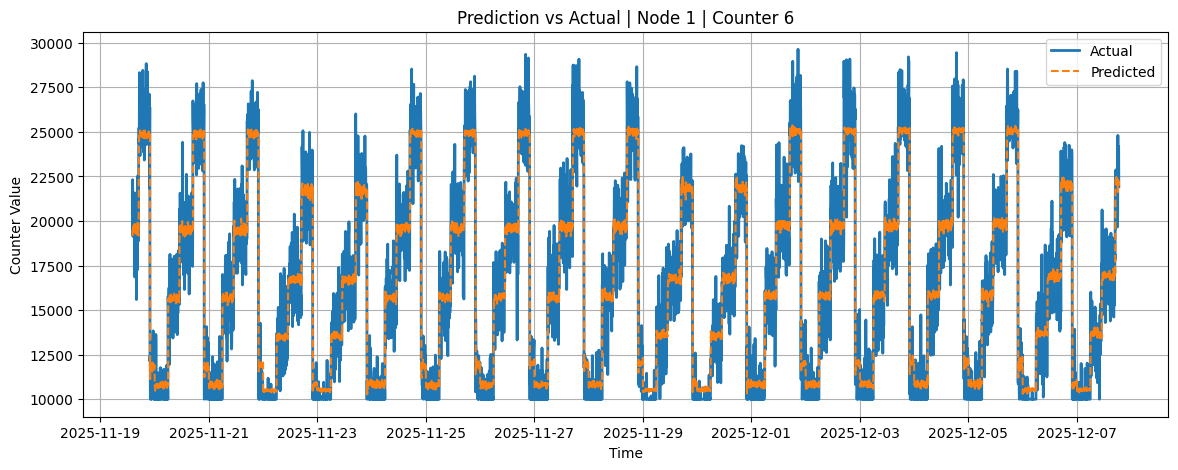

In [14]:
def plot_single_node_counter(
    time_index_test,
    Y_test_inv, 
    Y_pred_inv,
    node_idx,            # index node (0..n_nodes-1)
    counter_idx,         # index counter trong target_counters (0..n_target_counters-1)
    target_counters,
    node_ids,
    title_prefix="Prediction vs Actual"
):
    """
    Vẽ biểu đồ đường cho 1 node và 1 counter.
    """
    actual = Y_test_inv[:, node_idx, counter_idx]
    pred   = Y_pred_inv[:, node_idx, counter_idx]

    counter_id = target_counters[counter_idx]
    node_id    = node_ids[node_idx]

    plt.figure(figsize=(14,5))
    plt.plot(time_index_test, actual, label="Actual", linewidth=2)
    plt.plot(time_index_test, pred, label="Predicted", linestyle="--")
    
    plt.title(f"{title_prefix} | Node {node_id} | Counter {counter_id}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend()
    plt.show()

time_index = df_pivot.index[n_past:]       # thời gian tương ứng với X,Y
time_index_train = time_index[:len(X_train)]
time_index_test  = time_index[len(X_train):]

plot_single_node_counter(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx=0,
    counter_idx=0,
    target_counters=target_counters,
    node_ids=node_ids
)

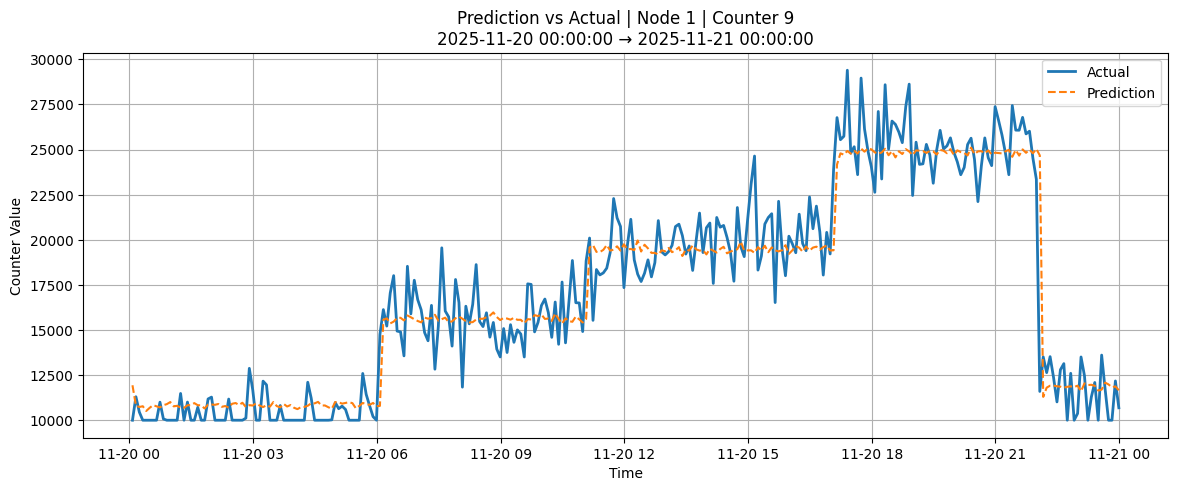

In [18]:
def plot_single_node_counter_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx,
    counter_idx,
    target_counters,
    node_ids,
    start_time,
    end_time,
    title_prefix="Prediction vs Actual"
):
    """
    Vẽ biểu đồ đường cho 1 node và 1 counter trong khoảng thời gian chỉ định.
    
    start_time, end_time: dạng string '2025-01-01 00:00:00' hoặc datetime
    """

    # Convert thời gian nếu cần
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)

    # --- Tìm index trong đoạn thời gian X -> Y ---
    mask = (time_index_test >= start_time) & (time_index_test <= end_time)

    if mask.sum() == 0:
        print("❌ Không có dữ liệu trong khoảng thời gian yêu cầu!")
        return

    t = time_index_test[mask]
    actual = Y_test_inv[mask, node_idx, counter_idx]
    pred   = Y_pred_inv[mask, node_idx, counter_idx]

    counter_id = target_counters[counter_idx]
    node_id = node_ids[node_idx]

    # --- Vẽ ---
    plt.figure(figsize=(14, 5))
    plt.plot(t, actual, label="Actual", linewidth=2)
    plt.plot(t, pred, label="Prediction", linestyle="--")

    plt.title(f"{title_prefix} | Node {node_id} | Counter {counter_id}\n{start_time} → {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_single_node_counter_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    node_idx=0,
    counter_idx=1,
    target_counters=target_counters,
    node_ids=node_ids,
    start_time="2025-11-20 00:00:00",
    end_time="2025-11-21 00:00:00"
)

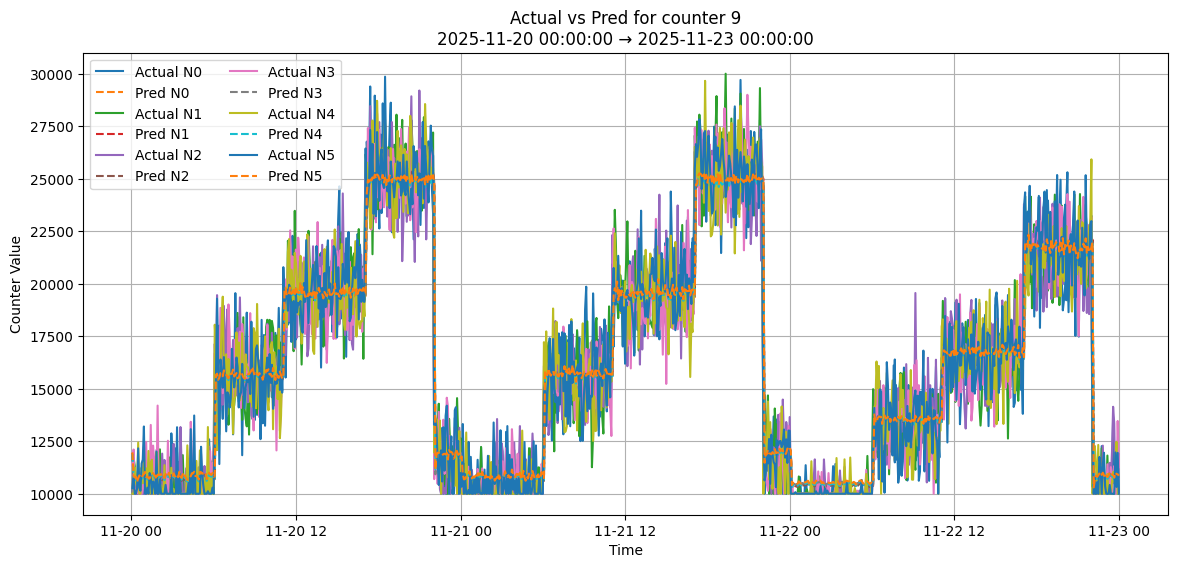

In [19]:
def plot_all_nodes_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    counter_idx,
    target_counters,
    node_ids,
    start_time,
    end_time
):
    if isinstance(start_time, str):
        start_time = pd.to_datetime(start_time)
    if isinstance(end_time, str):
        end_time = pd.to_datetime(end_time)

    mask = (time_index_test >= start_time) & (time_index_test <= end_time)

    if mask.sum() == 0:
        print("❌ Không có dữ liệu trong khoảng thời gian yêu cầu!")
        return

    t = time_index_test[mask]
    n_nodes = Y_test_inv.shape[1]

    plt.figure(figsize=(14, 6))

    for i in range(n_nodes):
        plt.plot(t, Y_test_inv[mask, i, counter_idx], label=f"Actual N{i}")
        plt.plot(t, Y_pred_inv[mask, i, counter_idx], linestyle="--", label=f"Pred N{i}")

    counter_id = target_counters[counter_idx]

    plt.title(f"Actual vs Pred for counter {counter_id}\n{start_time} → {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Counter Value")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.show()

plot_all_nodes_timerange(
    time_index_test,
    Y_test_inv,
    Y_pred_inv,
    counter_idx=1,
    target_counters=target_counters,
    node_ids=node_ids,
    start_time="2025-11-20 00:00:00",
    end_time="2025-11-23 00:00:00"
)

In [20]:
def evaluate_weekday_vs_weekend(Y_test, Y_pred, time_index_test):
    """
    Đánh giá MAE, RMSE giữa ngày trong tuần (Mon-Fri) và cuối tuần (Sat-Sun).
    
    Y_test_inv, Y_pred_inv: (N_test, n_nodes, n_target_counters)
    time_index_test: DatetimeIndex hoặc Series có length = N_test
    """
    # Đảm bảo time_index_test là DatetimeIndex
    time_index_test = pd.to_datetime(time_index_test)
    
    # Tạo mask
    weekday_mask = time_index_test.weekday < 5    # 0..4: Mon-Fri
    weekend_mask = time_index_test.weekday >= 5   # 5..6: Sat-Sun
    
    results = {}
    
    def _calc_metrics(mask, name):
        if mask.sum() == 0:
            return {f"{name}_MAE": np.nan, f"{name}_RMSE": np.nan}
        
        actual = Y_test[mask].reshape(-1)
        pred   = Y_pred[mask].reshape(-1)
        
        mae  = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        return {f"{name}_MAE": mae, f"{name}_RMSE": rmse}
    
    results.update(_calc_metrics(weekday_mask, "weekday"))
    results.update(_calc_metrics(weekend_mask, "weekend"))
    
    return results

weekday_weekend_metrics = evaluate_weekday_vs_weekend(
    Y_test, Y_pred_scaled, time_index_test
)
print(weekday_weekend_metrics)

{'weekday_MAE': 0.05958268599539968, 'weekday_RMSE': 0.08433986185183662, 'weekend_MAE': 0.05292687666832246, 'weekend_RMSE': 0.07427610779594823}


In [21]:
# Hàm đánh giá theo từng giờ trong ngày
def evaluate_by_hour_of_day(Y_test, Y_pred, time_index_test):
    """
    Đánh giá MAE, RMSE cho từng giờ trong ngày (0-23).
    
    Returns: list[dict] để dễ chuyển thành DataFrame.
    """
    time_index_test = pd.to_datetime(time_index_test)
    hours = time_index_test.hour.values  # array (N_test,)
    
    results = []
    
    for h in range(24):
        mask = (hours == h)
        if mask.sum() == 0:
            # Không có mẫu nào ở giờ này
            results.append({
                "hour": h,
                "MAE": np.nan,
                "RMSE": np.nan,
                "n_samples": 0
            })
            continue
        
        actual = Y_test[mask].reshape(-1)
        pred   = Y_pred[mask].reshape(-1)
        
        mae  = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        
        results.append({
            "hour": h,
            "MAE": mae,
            "RMSE": rmse,
            "n_samples": mask.sum()
        })
    
    return results

hour_metrics = evaluate_by_hour_of_day(Y_test, Y_pred_scaled, time_index_test)

import pandas as pd
df_hour_metrics = pd.DataFrame(hour_metrics)
print(df_hour_metrics)

    hour       MAE      RMSE  n_samples
0      0  0.036167  0.042940        216
1      1  0.033627  0.038318        216
2      2  0.034368  0.039477        216
3      3  0.033743  0.038335        216
4      4  0.033980  0.038906        216
5      5  0.033940  0.039199        216
6      6  0.073660  0.098361        216
7      7  0.061564  0.077111        216
8      8  0.060060  0.075230        216
9      9  0.058862  0.073912        216
10    10  0.061277  0.075979        216
11    11  0.070681  0.091994        216
12    12  0.060005  0.075514        216
13    13  0.060399  0.076232        216
14    14  0.059489  0.074984        225
15    15  0.060764  0.076027        228
16    16  0.059706  0.075896        228
17    17  0.081282  0.112286        228
18    18  0.063820  0.079419        224
19    19  0.062419  0.077936        216
20    20  0.062191  0.077704        216
21    21  0.062698  0.078201        216
22    22  0.100062  0.195162        216
23    23  0.052515  0.063860        216


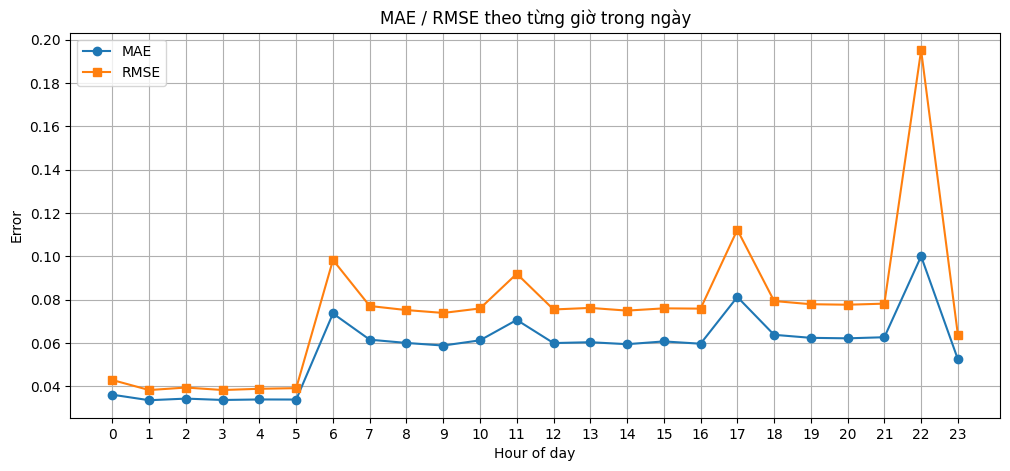

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_hour_metrics["hour"], df_hour_metrics["MAE"], marker="o", label="MAE")
plt.plot(df_hour_metrics["hour"], df_hour_metrics["RMSE"], marker="s", label="RMSE")
plt.xlabel("Hour of day")
plt.ylabel("Error")
plt.title("MAE / RMSE theo từng giờ trong ngày")
plt.grid(True)
plt.legend()
plt.xticks(range(0, 24))
plt.show()

In [23]:
def recursive_multi_step_forecast(
    model,
    data_scaled,
    n_past,
    n_steps,
    target_col_indices,
    n_nodes,
    n_target_counters
):
    """
    Dự đoán n_steps bước tương lai theo kiểu:
    - Lấy cửa sổ n_past bước cuối
    - Dự đoán 1 bước
    - Nhét dự đoán vào cuối cửa sổ (thay thế các cột target)
    - Trượt cửa sổ rồi dự đoán tiếp

    Params
    -------
    model : keras Model
        Đã train, input (None, n_past, n_features_all), output (None, n_nodes, n_target_counters)
    data_scaled : np.ndarray
        Dữ liệu chuẩn hóa, shape (n_time, n_features_all)
    n_past : int
        Số timestep dùng làm input
    n_steps : int
        Số timestep tương lai muốn dự đoán
    target_col_indices : list[int]
        Vị trí các cột tương ứng với (node, counter) cần dự đoán trong data_scaled
    n_nodes : int
    n_target_counters : int

    Returns
    -------
    preds_scaled : np.ndarray
        Dự đoán cho các target (đã scale), shape (n_steps, n_nodes, n_target_counters)
    future_full_scaled : np.ndarray
        Toàn bộ vector feature tại từng bước tương lai, shape (n_steps, n_features_all)
        (để nếu muốn tiếp tục feed tiếp, hoặc inverse_transform sau này)
    """

    n_time, n_features_all = data_scaled.shape

    # Lấy cửa sổ cuối cùng làm điểm bắt đầu
    window = data_scaled[-n_past:].copy()   # (n_past, n_features_all)

    preds_list = []
    future_full_list = []

    for step in range(n_steps):
        # 1) Chuẩn bị input cho model: (1, n_past, n_features_all)
        x_input = window.reshape(1, n_past, n_features_all)

        # 2) Dự đoán 1 bước
        y_pred = model.predict(x_input, verbose=0)  # (1, n_nodes, n_target_counters)

        # Flatten để gán vào đúng cột trong full feature vector
        y_pred_flat = y_pred.reshape(n_nodes * n_target_counters)  # (n_nodes * n_target_counters,)

        # 3) Tạo "dòng dữ liệu mới" cho time step tương lai
        #    Bắt đầu từ dòng cuối cùng của cửa sổ, sau đó ghi đè các cột target bằng giá trị dự đoán
        new_row = window[-1].copy()          # (n_features_all,)
        new_row[target_col_indices] = y_pred_flat

        # Lưu lại
        preds_list.append(y_pred.squeeze(0))   # (n_nodes, n_target_counters)
        future_full_list.append(new_row.copy())

        # 4) Cập nhật cửa sổ: bỏ timestep đầu, thêm new_row vào cuối
        window = np.vstack([window[1:], new_row])

    preds_scaled = np.array(preds_list)          # (n_steps, n_nodes, n_target_counters)
    future_full_scaled = np.array(future_full_list)  # (n_steps, n_features_all)

    return preds_scaled, future_full_scaled

n_steps = 24

preds_scaled, future_full_scaled = recursive_multi_step_forecast(
    model=model,
    data_scaled=data_scaled,
    n_past=n_past,
    n_steps=n_steps,
    target_col_indices=target_col_indices,
    n_nodes=n_nodes,
    n_target_counters=n_target_counters
)

print("preds_scaled shape:", preds_scaled.shape)         # (12, n_nodes, n_target_counters)
print("future_full_scaled shape:", future_full_scaled.shape)  # (12, n_features_all)

preds_scaled shape: (24, 6, 2)
future_full_scaled shape: (24, 120)


In [ ]:
# model.save("lstm_forecast_model.keras")
# print("✅ Saved model to lstm_forecast_model.keras")
# model.save("lstm_forecast_model.h5")
# print("✅ Saved model to lstm_forecast_model.h5")